## Large-Scale Simulation

In this notebook, we perform large-scale pricing simulations across three numerical methods:
 - Monte Carlo Simulation
 - Finite Difference (PDE: Crank-Nicolson)
 - Binomial Tree Method

Each method is benchmarked against the analytical Black-Scholes price. We compare:
 - Accuracy: Absolute error vs. benchmark
 - Performance: Runtime for increasing resolution
 - Convergence Behavior: How fast methods approach the true price

In [16]:
# --- Setup & Imports ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os, sys

sys.path.append(os.path.abspath("../../"))

from pricing.bsm import black_scholes_price
from pricing.monte_carlo import MonteCarloPricer
from pricing.pde import CrankNicolsonSolver
from pricing.binomial_tree import BinomialVanillaPricer

In [17]:
# --- Benchmark Parameters ---
S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
is_call = True

# Reference BSM price
bsm_price = black_scholes_price(S0, K, T, r, sigma, option_type="call")
print(f"BSM Benchmark Price: {bsm_price:.4f}")

BSM Benchmark Price: 10.4506


In [18]:
# --- Monte Carlo Convergence ---
mc_paths = [1000, 5000, 10000, 20000, 50000]
mc_results = []

for n in mc_paths:
    start = time.time()
    pricer = MonteCarloPricer(S0, K, T, r, sigma, n_paths=n, option_type='call')
    price, ci = pricer.price_with_confidence_interval()
    elapsed = time.time() - start
    abs_error = abs(price - bsm_price)
    mc_results.append([n, price, ci[0], ci[1], abs_error, elapsed])

mc_df = pd.DataFrame(mc_results, columns=["Paths", "Price", "CI Low", "CI High", "Abs Error", "Runtime (s)"])

In [29]:
# --- PDE (Crank-Nicolson) ---
pde_steps = [20, 40, 80, 160, 320]
pde_results = []

for N in pde_steps:
    start = time.time()
    solver = CrankNicolsonSolver(S_max=200, K=K, T=T, r=r, sigma=sigma, M=N, N=N, is_call=is_call)
    V, grid = solver.solve()
    price = np.interp(S0, grid, V)
    elapsed = time.time() - start
    abs_error = abs(price - bsm_price)
    pde_results.append([N, price, abs_error, elapsed])

pde_df = pd.DataFrame(pde_results, columns=["Grid Size", "Price", "Abs Error", "Runtime (s)"])

In [30]:
# --- Binomial Tree ---
binomial_steps = [10, 50, 100, 200, 500]
binomial_results = []

for N in binomial_steps:
    start = time.time()
    pricer = BinomialVanillaPricer(S0, K, T, r, sigma, N, is_call=is_call)
    price = pricer.price()
    elapsed = time.time() - start
    abs_error = abs(price - bsm_price)
    binomial_results.append([N, price, abs_error, elapsed])

binomial_df = pd.DataFrame(binomial_results, columns=["Steps", "Price", "Abs Error", "Runtime (s)"])

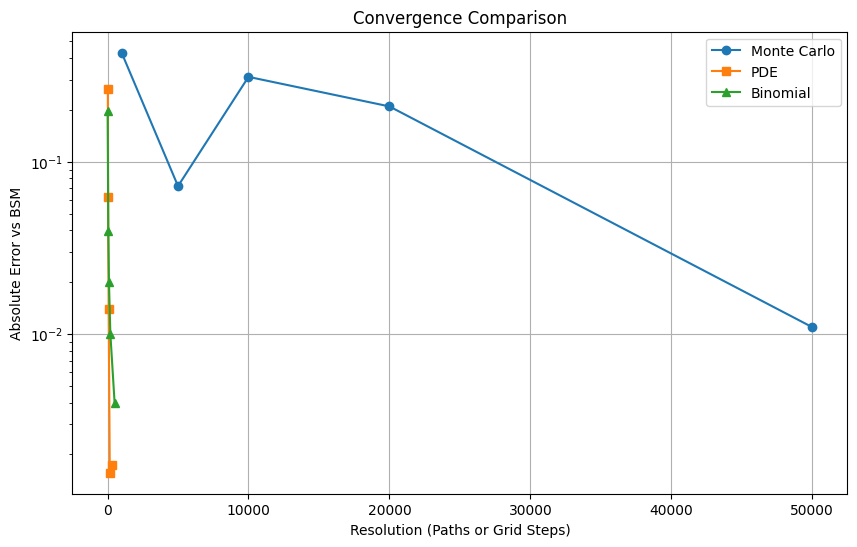

In [31]:
# --- Plot Convergence ---
plt.figure(figsize=(10, 6))
plt.plot(mc_df["Paths"], mc_df["Abs Error"], marker='o', label="Monte Carlo")
plt.plot(pde_df["Grid Size"], pde_df["Abs Error"], marker='s', label="PDE")
plt.plot(binomial_df["Steps"], binomial_df["Abs Error"], marker='^', label="Binomial")

plt.xlabel("Resolution (Paths or Grid Steps)")
plt.ylabel("Absolute Error vs BSM")
plt.yscale("log")
plt.title("Convergence Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# --- Summary Tables ---
print("Monte Carlo Summary:")
display(mc_df)

print("PDE Summary:")
display(pde_df)

print("Binomial Tree Summary:")
display(binomial_df)

Monte Carlo Summary:


,Paths,Price,CI Low,CI High,Abs Error,Runtime (s)
0,1000,10.020948,9.161144,10.880751,0.429636,0.012880
1,5000,10.378376,9.974550,10.782203,0.072207,0.033747
2,10000,10.139421,9.855890,10.422952,0.311163,0.037086
3,20000,10.241023,10.038465,10.443581,0.209561,0.055430
4,50000,10.439626,10.310091,10.569161,0.010958,0.135483


PDE Summary:


,Grid Size,Price,Abs Error,Runtime (s)
0,20,10.184990,0.265593,0.001484
1,40,10.387999,0.062585,0.003171
2,80,10.436626,0.013958,0.011676
3,160,10.449018,0.001565,0.044224
4,320,10.452311,0.001728,0.172972


Binomial Tree Summary:


,Steps,Price,Abs Error,Runtime (s)
0,10,10.253409,0.197175,0.000222
1,50,10.410692,0.039892,0.000343
2,100,10.430612,0.019972,0.000702
3,200,10.440591,0.009992,0.001638
4,500,10.446585,0.003998,0.005332
